In [1]:
import os
os.environ['DISPLAY'] = "localhost:12.0" #linux env variable for ase gui
from ase.build import nanotube
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np

1. calculate the radius of CNT

In [2]:
cnt_dict = {}
for i in range (6,13):
    cnt_dict[f'{i}-{i}'] = nanotube(i, i, length = 6, bond=1.42, vacuum=10)
# cnt_12.edit()
# view(cnt_dict['12-12'], viewer='ngl')

In [3]:
cnt_length = cnt_dict['12-12'].cell.cellpar()[2]
cnt_length 

14.757072880486835

In [4]:
def fit_circle(x, y):
    
    def calc_R(xc, yc):
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    from scipy.optimize import leastsq   
    center_estimate = x.mean(), y.mean()
    center_2, iter = leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(xc_2, yc_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)
    # residu2_2  = sum((Ri_2**2-R_2**2)**2)
    return (xc_2, yc_2), R_2, residu_2

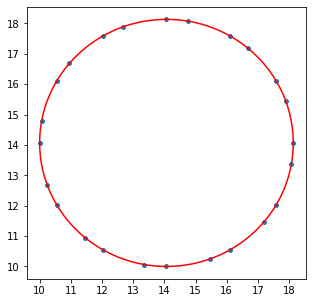

In [5]:
#test the fitting performance
x = cnt_dict['6-6'].get_positions()[:,0]
y = cnt_dict['6-6'].get_positions()[:,1]

plt.figure(figsize=(5,5))
plt.plot(x, y, '.')

center, r, residu = fit_circle(x, y)
x_fit = np.linspace(x.min(), x.max(), 100000)
y_fit = np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]
y_fit1 = -np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]
plt.plot(x_fit, y_fit, '-', c='r')
plt.plot(x_fit, y_fit1, '-', c='r')

In [6]:
from ase.data import vdw_radii
c_vdw_r = vdw_radii[6]
c_vdw_r

1.7

In [7]:
cnt_dict_fit = {}
for i in cnt_dict.keys():
    x = cnt_dict[i].get_positions()[:,0]
    y = cnt_dict[i].get_positions()[:,1]
    center, r, residu = fit_circle(x, y)
    cnt_dict_fit[i] = [*center, r, residu]
    
cnt_dict_fit

{'6-6': [14.068000345428846,
  14.068000345428846,
  4.068000345428846,
  1.0886280492049963e-28],
 '7-7': [14.74600040300032,
  14.732729623295327,
  4.746000403000318,
  2.271919407036514e-28],
 '8-8': [15.424000460571794,
  15.424000460571794,
  5.424000460571793,
  1.4199496293978212e-28],
 '9-9': [16.102000518143267,
  16.091676899037928,
  6.102000518143267,
  3.407879110554771e-28],
 '10-10': [16.78000057571474,
  16.78000057571474,
  6.78000057571474,
  7.951717924627799e-28],
 '11-11': [17.458000633286215,
  17.44955324819579,
  7.458000633286216,
  2.6979042958558604e-28],
 '12-12': [18.136000690857692,
  18.136000690857692,
  8.136000690857692,
  8.898351010893013e-28]}

2.calculate the water numbers of different CNT with different water densities.

In [8]:
def calc_volume(r:float, l:float):
    """_summary_

    Args:
        r (float): radius of the nanotube
        l (float): length of the nanotube

    Returns:
        _type_: volume
    """：去！
    return np.pi * r**2 * l

In [7]:
def get_n_water(v:float, d:float):
    """_summary_

    Args:
        v (float): volume of the nanotube, unit: A^3.
        d (float): density of the filling water, unit: g/cm^3.

    Returns:
        _type_: number of water molecules
    """
    m0 = 1.008*2 + 15.999
    NA = 6.022140857e23
    u_a_cm = 1e-8 #1 A = 10^-8 cm
    
    n_water =  d * v * u_a_cm**3 / (m0 / NA)

    return n_water

In [9]:
v = 26 * 26 * 10
get_n_water(v, 1)

225.9765317419928

In [10]:
n_water_dict = {}
for i in cnt_dict_fit.keys():
    v = calc_volume(cnt_dict_fit[i][2], cnt_length)
    n_water_dict[i] = get_n_water(v, 1)
n_water_dict

{'6-6': 25.646535139673418,
 '7-7': 34.90778394011102,
 '8-8': 45.59384024830826,
 '9-9': 57.70470406426516,
 '10-10': 71.24037538798164,
 '11-11': 86.20085421945782,
 '12-12': 102.58614055869367}

3.fill water by Packmol

In [11]:
#generate pdb file
from ase.build import molecule
molecule('H2O', vacuum=3.0).write('H2O.pdb')

for i in cnt_dict.items():
    i[1].write(f'{i[0]}.pdb')

In [12]:
Packmol_path = '~/bin/packmol'

def gen_packmol_inf(cnt_pdb, density, r_fit):
    from ase import io
    from random import randint
    tag = randint(0,10000)
   
    cnt = io.read(cnt_pdb)
    cnt_type = cnt_pdb.split('.')[0]
    cell = cnt.cell.cellpar()
    v = calc_volume(r_fit, cell[2])
    n_water = round(get_n_water(v, density))
    
    ret = f'''tolerance 1.5
output {cnt_type}-d-{density}.pdb
structure {cnt_type}.pdb
  number 1
  center
  fixed {cell[0]/2} {cell[1]/2} {cell[2]/2} 0 0 0
end structure

structure H2O.pdb #need change to your system
  number  {n_water} 
  inside cylinder {cell[0]/2} {cell[1]/2} 0 0 0 1 {r_fit} {cell[2]-1.5} 
end structure
'''
    inp_file = f'packmol-{cnt_type.split("/")[-1]}-{tag}.inp'
    with open(inp_file, 'w') as f_:
        f_.write(ret)
    return inp_file

def run_packmol(inp_file):
    from os import popen
    ret_mag = popen(f'{Packmol_path} < {inp_file}').read()
    if not 'Success!' in ret_mag:
        print (ret_mag)
        raise Exception(f'Packmol failed: {inp_file}')
    else:
        print (f'Packmol finished: {inp_file}')
    return None

def solvate_cnt(cnt_pdb, density, r_fit):
#only support when alpha=beta=gamma=90
    inp_file = gen_packmol_inf(cnt_pdb, density, r_fit)
    run_packmol(inp_file)
    
    
    from ase import io
    # cnt_solv = io.read(f'{cnt_pdb.split(".")[0]}-d-{density}.pdb')
    cnt = io.read(cnt_pdb)
    cell_vect = cnt.cell.cellpar()
    with open (f'{cnt_pdb.split(".")[0]}-d-{density}.pdb', 'r') as f_:
        lines = f_.readlines()
        lines[4] = f'CRYST1{cell_vect[0]:>9}{cell_vect[1]:>9}{cell_vect[2]:>9}\
{cell_vect[3]:>7}{cell_vect[4]:>7}{cell_vect[5]:>7}\n'
    with open (f'{cnt_pdb.split(".")[0]}-d-{density}.pdb', 'w') as f_:
        f_.writelines(lines)
    
    # the following will remove the CONECT part of pdb file
    # cnt_solv.set_pbc([True, True, True])
    # cnt_solv.set_cell(cell_vect[0:3])
    # cnt_solv.center()
    # cnt_solv.write(f'{cnt_pdb.split(".")[0]}-d-{density}.pdb')
    
    from os import remove
    remove(inp_file)
    return None

In [17]:
os.chdir('/home/kwwan/work/cnt/model-build/lmp-pre')

for i in cnt_dict_fit.items():
    solvate_cnt(f'{i[0]}.pdb', 0.40, i[1][2])

import glob
# from vac_cnt.add_connect_part import add_connect_part
# _list = glob.glob("*-d*.pdb")
# for i in _list:
#     add_connect_part(i)
    
os.chdir('..')

Packmol finished: packmol-6-6-1677.inp
Packmol finished: packmol-7-7-1391.inp
Packmol finished: packmol-8-8-9877.inp
Packmol finished: packmol-9-9-8922.inp
Packmol finished: packmol-10-10-1852.inp
Packmol finished: packmol-11-11-2902.inp
Packmol finished: packmol-12-12-4226.inp


4.pre-optimize  

In [3]:
from ase.io import read, write
from ase.constraints import FixAtoms
cnt_solv = read('6-6-d-1.pdb')
cnt_solv.set_constraint(FixAtoms(indices=[atom.index for atom in cnt_solv if atom.symbol == 'C']))
# cnt_solv._get_constraints()

- method1: xtb  
can not optimze to the right state

In [7]:
# from xtb.ase.calculator import XTB
# cnt_solv.calc = XTB(method = 'GFN1-xTB', max_iterations=250)
# os.environ['OMP_NUM_THREADS'] = '12'
# os.environ['OMP_STACKSIZE'] = '30G'
# from ase.optimize.bfgs import BFGS
# BFGS(cnt_solv).run(fmax = 0.5)
# cnt_solv.write('6-6-d-1-xtb.pdb')

- method2: cp2k  
can not optimze to the right state

In [4]:
os.environ['CP2K_DATA_DIR'] = ''
cp2k_command = 'pwd_path=`pwd`; ssh node5 "cd ${pwd_path}; module load singularity/singularityCE_3.10.0;\
module load intel/impi/2018.4.274;\
mpirun -np 96 singularity exec --bind $PWD /home/kwwan/software/singularity/cp2k22_01.sif cp2k_shell.psmp"'

# cp2k_command = 'pwd_path=`pwd`;ssh node5 "cd ${pwd_path};module load gcc/9.3.0;\
# source /opt/intel/compilers_and_libraries_2018.5.274/linux/mkl/bin/mklvars.sh intel64;\
# source /home/kwwan/software/cp2k-7.1/cp2k-7.1/tools/toolchain/install/setup;\
# export PATH=$PATH:/home/kwwan/software/cp2k-7.1/cp2k-7.1/exe/local;\
# mpirun -n 96 cp2k_shell.popt"'
# os.environ['CP2K_DATA_DIR'] = '/home/kwwan/software/cp2k-7.1/cp2k-7.1/data'
os.environ['ASE_CP2K_COMMAND'] = cp2k_command
cp2k_command

'pwd_path=`pwd`; ssh node5 "cd ${pwd_path}; module load singularity/singularityCE_3.10.0;module load intel/impi/2018.4.274;mpirun -np 96 singularity exec --bind $PWD /home/kwwan/software/singularity/cp2k22_01.sif cp2k_shell.psmp"'

In [29]:
# from ase.calculators.cp2k import CP2K
# cnt_solv.set_calculator(CP2K())
# from ase.optimize.bfgs import BFGS
# BFGS(cnt_solv).run(fmax = 0.5)
# cnt_solv.write('6-6-d-1-cp2k.pdb')

- method3: vasp  
can not optimze to the right state

In [32]:
from glob import glob
cnt_pdb_list = glob('*-*-d-*.pdb')

In [37]:
path = '/home/kwwan/work/cnt/model-build/vasp-opt'
for i in cnt_pdb_list:
    tag = '.'.join(i.split('.')[:-1])
    if not os.path.exists(f'{path}/{tag}'):
        os.mkdir(f'{path}/{tag}')
    tmp = read(i)
    tmp.set_constraint(FixAtoms(indices=[atom.index for atom in tmp if atom.symbol == 'C']))
    tmp.write(f'{path}/{tag}/POSCAR', format='vasp', sort=True)

- 2 step method  
(1)lammps pre-opt

In [19]:
from gen_lmp_data.gen_lmp_data_vmd import gen_lmp_data
from glob import glob
_list = glob('lmp-pre/*-d*.pdb')
for i in _list:
    gen_lmp_data(i)

/home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64: /lib64/libGL.so.1: no version information available (required by /home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64)
/home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64: /lib64/libGL.so.1: no version information available (required by /home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64)
/home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64: /lib64/libGL.so.1: no version information available (required by /home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64)
/home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64: /lib64/libGL.so.1: no version information available (required by /home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64)
/home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64: /lib64/libGL.so.1: no version information available (required by /home/kwwan/software/vmd-1.9.4a51-path/vmd_home/vmd_LINUXAMD64)
/home/kwwan/software/vmd-1.9.4a51-p

In [21]:
_list = sorted(glob('lmp-pre/*-d*.data'))

import os
for i in _list:
    i_ = '.'.join(i.split('/')[-1].split('.')[:-1])
    if not os.path.exists(f'lmp-pre/{i_}'):
        os.mkdir(f'lmp-pre/{i_}')
    os.system(f'cp {i} lmp-pre/{i_}/lmp.data')
    os.system(f'ln -s ../input.lammps lmp-pre/{i_}')
    os.system(f'ln -s ../lmp.slurm lmp-pre/{i_}')

(2)cp2k opt

In [24]:
def gen_cp2k_input(file, work_dir):
    from ase.io import read
    traj = read(file, index=':')
    if file.split('/')[-1] == 'traj.dump':
        conv_dict = {1:'C', 2:'H', 3:'O'}
        traj[-1].set_chemical_symbols([conv_dict[i] for i in traj[-1].get_atomic_numbers()])
    traj[-1].write(f'{work_dir}/cp2k.cif')

    atom_type = traj[-1].get_chemical_symbols()
    atom_pos = traj[-1].get_positions()
    with open(f'{work_dir}/cp2k.xyz', 'w') as f:
        f.write(f'{len(atom_type)}\n\n')
        for i in range(0, len(atom_type)):
            f.write(f'{atom_type[i]:<8}{atom_pos[i,0]:<17}{atom_pos[i,1]:<17}{atom_pos[i,2]:<17}{i+1}\n')

    _list = traj[-1].get_chemical_symbols()
    ret = []
    for i in range(len(_list)):
        if _list[i] == 'C':
            if i > 1 and _list[i-1] == 'C':
                ret[-1] = f'..{i+1}'
            else:
                ret.append(f' {i+1}')
    return ''.join(ret)


In [29]:
from glob import glob
lmp_list = glob('/home/kwwan/work/cnt/model-build/lmp-pre-opt-6/*d-0.4*-lmp/traj.dump')

In [30]:
import os
work_dir = '/home/kwwan/work/cnt/aimd/1'
for i in lmp_list:
    tag = i.split('/')[-2].split('-lmp')[0]
    if not os.path.exists(f'{work_dir}/{tag}'):
        os.mkdir(f'{work_dir}/{tag}')
    # os.system(f'cp {work_dir}/cp2k.* {work_dir}/{tag}')
    # os.system(f'ln -s {work_dir}/{tag}/cp2k.inp {work_dir}/{tag}/inp.cp2k')
    fix_list = gen_cp2k_input(i, f'{work_dir}/{tag}')
    # os.system(f'sed -i "s/SET FIXEDLIST/SET FIXEDLIST {fix_list}/g" {work_dir}/{tag}/cp2k.inp')

5.test parameters  
CUTOFF:850 RELCUTOFF:70


6.cp2k aimd

In [5]:
work_dir = '/home/kwwan/work/cnt/model-build/aimd'
pdb_list = glob('/home/kwwan/work/cnt/model-build/cp2k-opt-6/*d-*/cp2k-pos-1-new.pdb')

In [11]:
# ! rm -rf !(cp2k.sh|cp2k.inp)
for i in pdb_list:
    tag = i.split('/')[-2].split('-lmp')[0]
    if not os.path.exists(f'{work_dir}/{tag}'):
        os.mkdir(f'{work_dir}/{tag}')
    fix_list = gen_cp2k_input(i, f'{work_dir}/{tag}')
    os.system(f'cp {work_dir}/cp2k.* {work_dir}/{tag}')
    os.system(f'ln -s {work_dir}/{tag}/cp2k.inp {work_dir}/{tag}/inp.cp2k')
    os.system(f'sed -i "s/SET FIXEDLIST/SET FIXEDLIST {fix_list}/g" {work_dir}/{tag}/cp2k.inp')